In [1]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys
from datetime import datetime, timedelta
from itertools import chain

from datetime import date


sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

# Notes on calculations

Calulation and definitions found here: 

https://www.css.cornell.edu/faculty/dgr2/_static/files/R_html/ModelEvaluation.html#1_Introduction

## Although they say observed - predicted which is clearly wrong

In [2]:
path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/Final_dataset_as_of_20240209.csv"

small_fire = fv.prep_fire_files(path)
small_fire = small_fire[~small_fire.geometry.isna()]

fire = fv.prep_fire_files(path)
fire = fire[~fire.geometry.isna()]

In [3]:
#fire[fire.fireID == '9791'].t.max() ## Yes, has FWI from when fires is not burning. 

#fire = fire[~fire.geometry.isna()] ## Subset to just when fires are burning (Should do? What about lead up to?)




In [4]:

for i in range(1,9):
    small_fire[f"fwi_error_{i}"] =small_fire["FWI"] - small_fire[f"FWI_lead_{i}"]

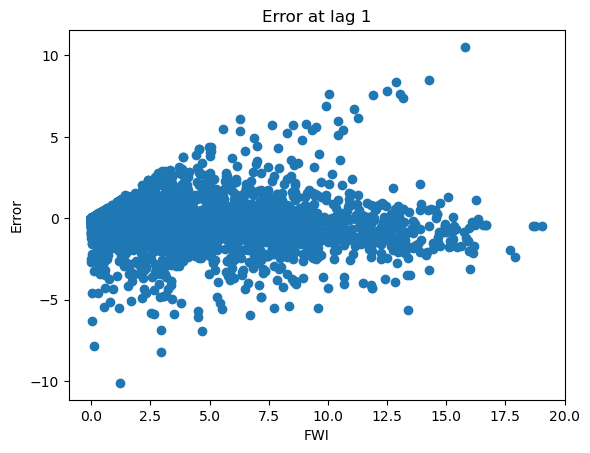

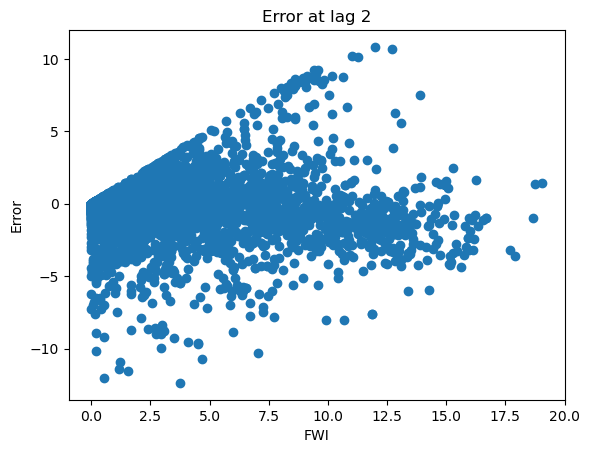

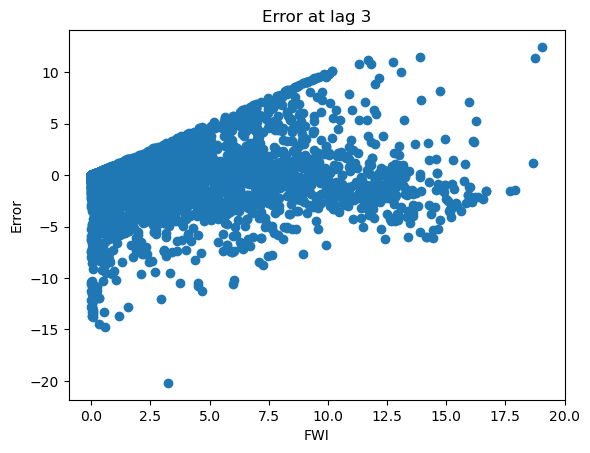

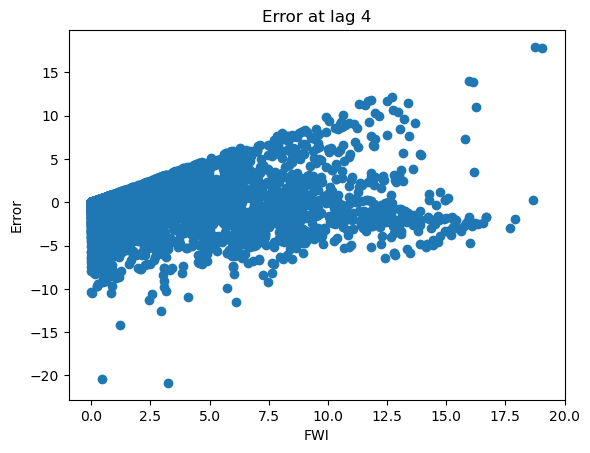

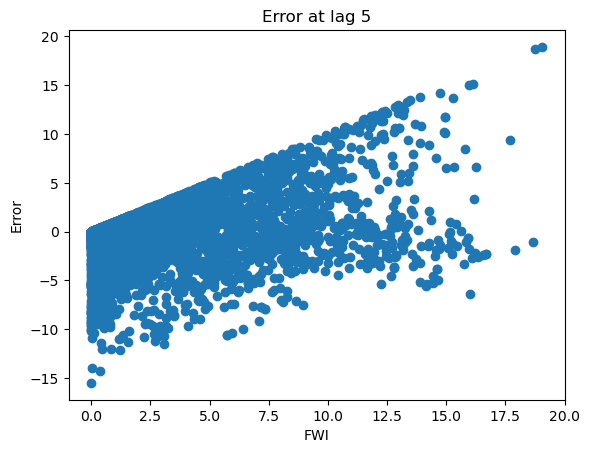

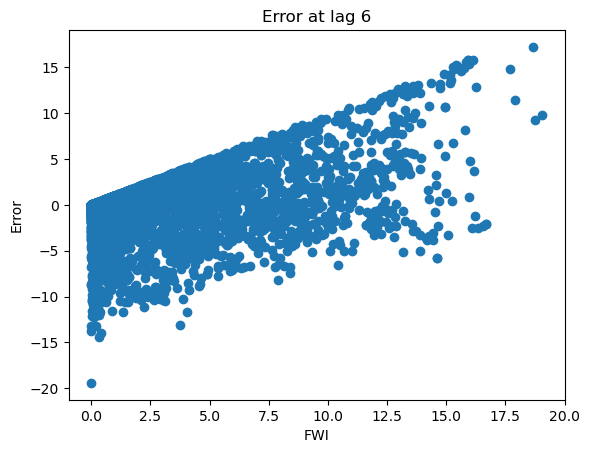

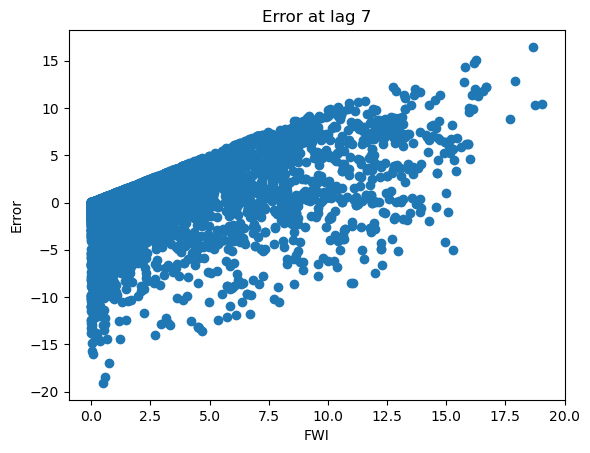

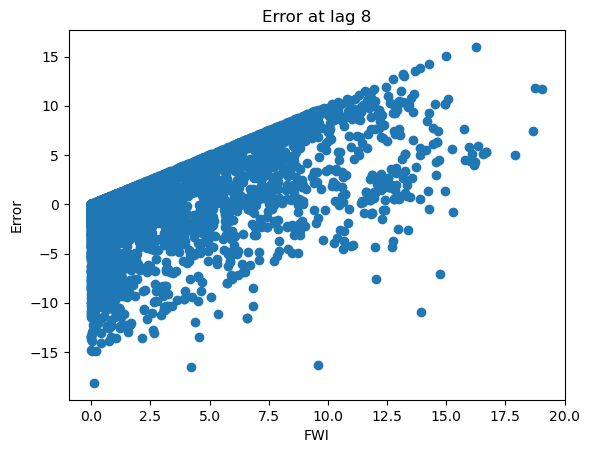

In [5]:
for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    plt.scatter(small_fire.FWI, small_fire[f"fwi_error_{i}"])
    plt.xlabel("FWI")
    plt.ylabel("Error")
    plt.title(f"Error at lag {i}")
    plt.show()

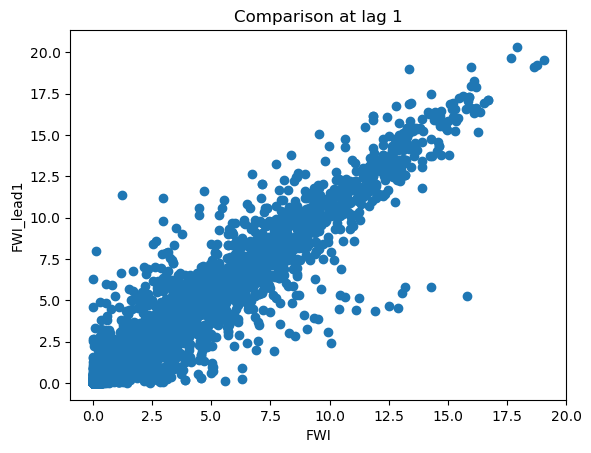

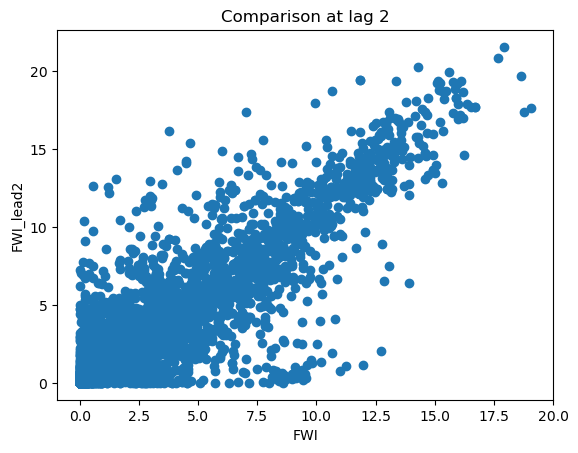

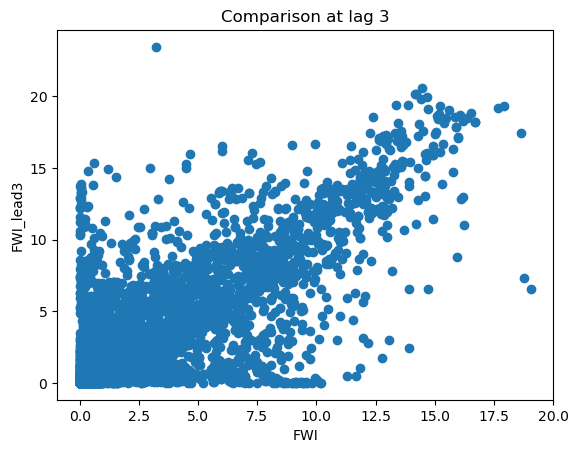

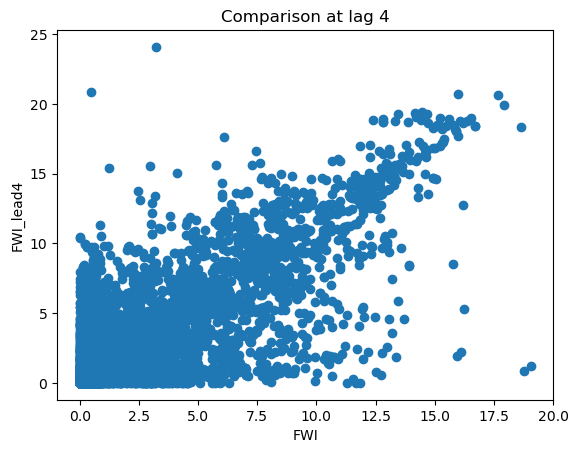

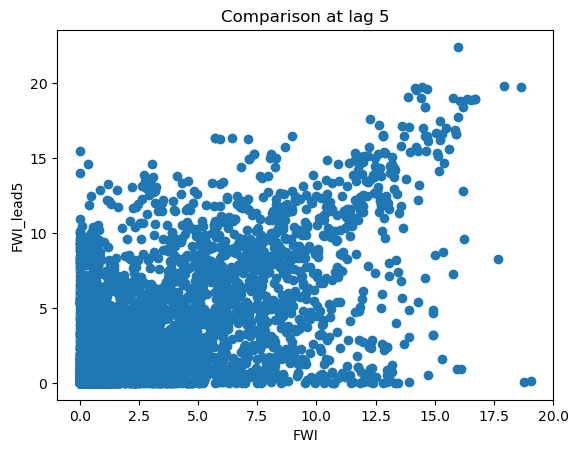

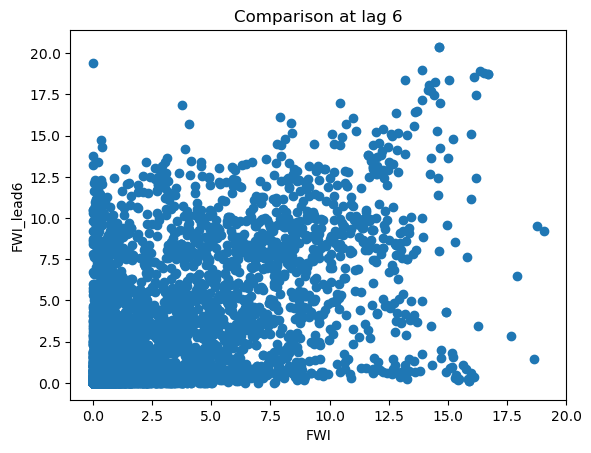

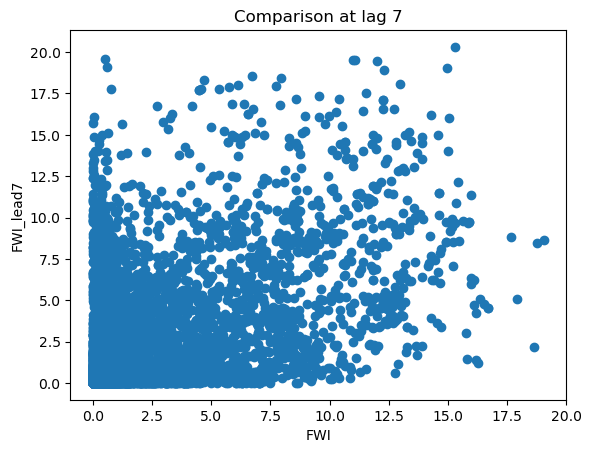

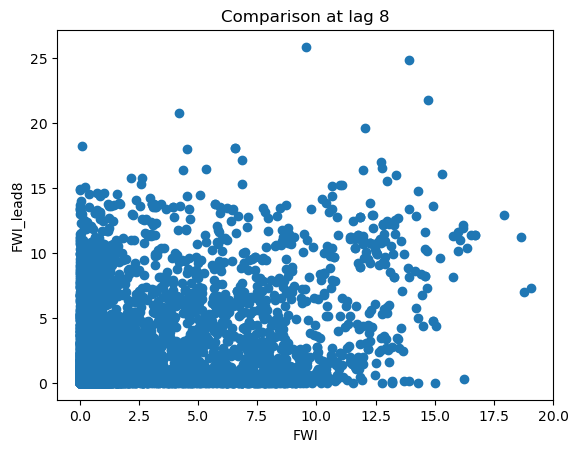

In [6]:
for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    plt.scatter(small_fire.FWI, small_fire[f"FWI_lead_{i}"])
    plt.xlabel("FWI")
    plt.ylabel(f"FWI_lead{i}")
    plt.title(f"Comparison at lag {i}")
    plt.show()

In [7]:
### Ok, see if you can get rid of duplicates for the purposes of plotting 

small_fire = small_fire[['GEOS-5.IMERGEARLY',
       'FWI', 'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4',
       'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8', 'pre_fire',
       'fwi_error_1', 'fwi_error_2', 'fwi_error_3', 'fwi_error_4',
       'fwi_error_5', 'fwi_error_6', 'fwi_error_7', 'fwi_error_8']]
small_fire = small_fire.drop_duplicates()
#small_fire.columns

In [8]:
len(small_fire)

5120

In [9]:
len(small_fire)

5120

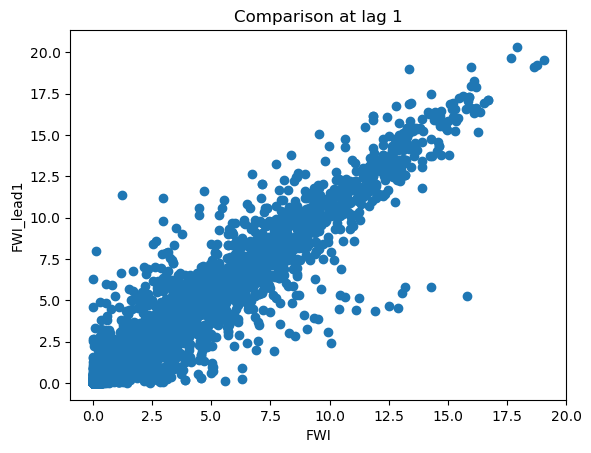

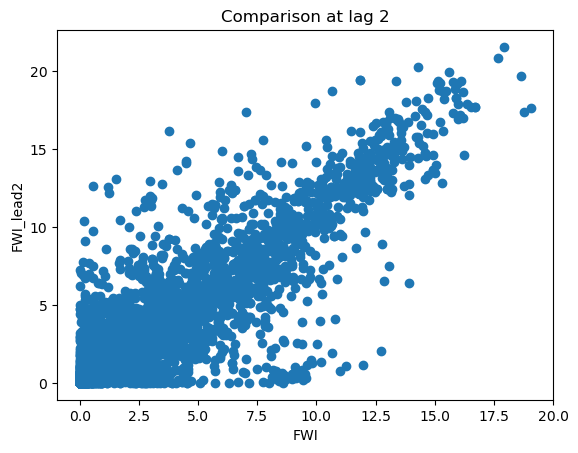

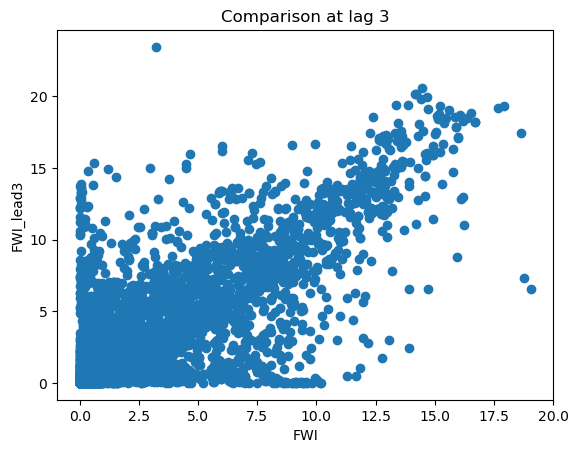

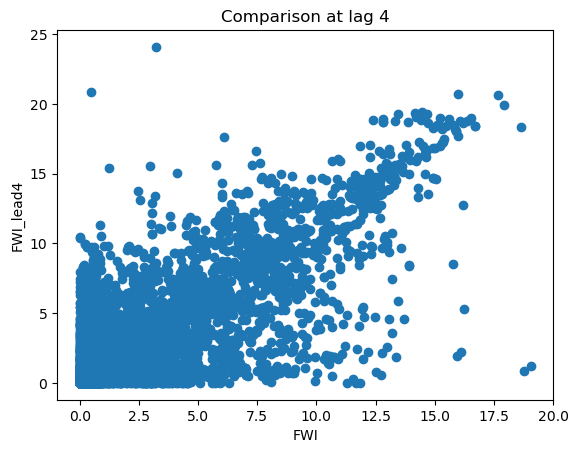

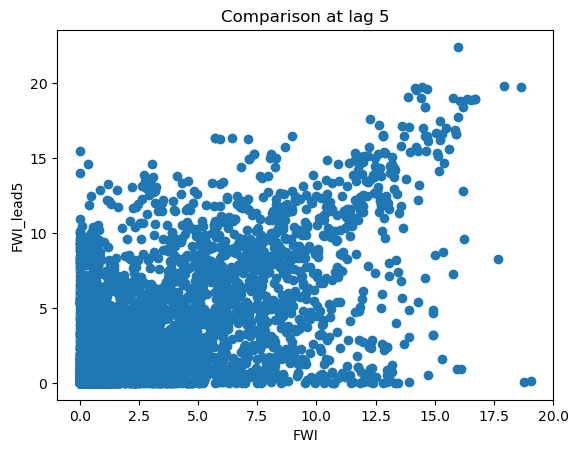

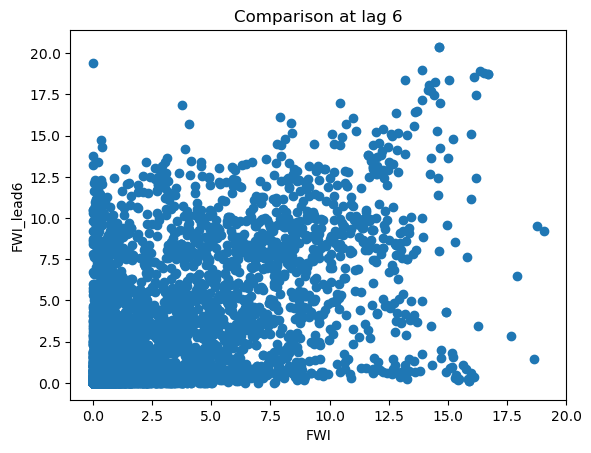

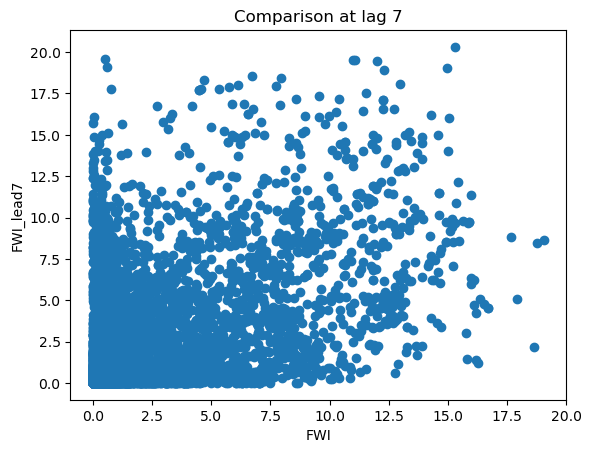

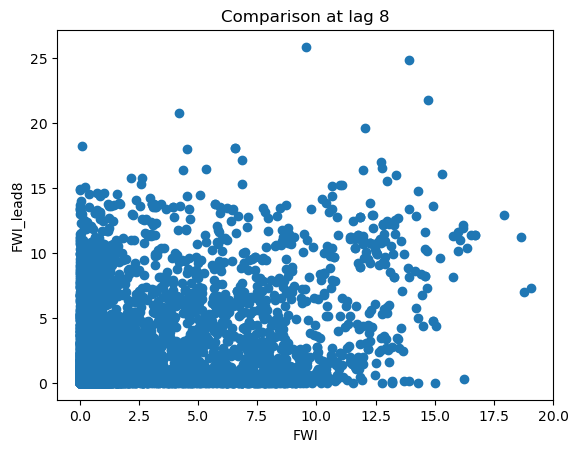

In [10]:
for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    plt.scatter(small_fire.FWI, small_fire[f"FWI_lead_{i}"])
    plt.xlabel("FWI")
    plt.ylabel(f"FWI_lead{i}")
    plt.title(f"Comparison at lag {i}")
    plt.show()

In [11]:
### BAD: BUT I JUST WANT TO LOOK TO SEE IF SUPER DIFFERENT

#small_fire["FWI"] = small_fire["GEOS-5.IMERGEARLY"]
#fire["FWI"] = fire["GEOS-5.IMERGEARLY"]

log_fire = small_fire
small_fire.columns
#log_fire = np.log(small_fire[['FWI', 'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3','FWI_lead_4', 'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8']] + 1)

Index(['GEOS-5.IMERGEARLY', 'FWI', 'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3',
       'FWI_lead_4', 'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8',
       'pre_fire', 'fwi_error_1', 'fwi_error_2', 'fwi_error_3', 'fwi_error_4',
       'fwi_error_5', 'fwi_error_6', 'fwi_error_7', 'fwi_error_8'],
      dtype='object')

In [12]:
boot_df = small_fire.sample(n = len(small_fire)**2, replace = True, random_state = 4001, axis =0, ignore_index = True)

print(len(boot_df))

26214400


In [160]:
def fr_sq(s, s_pred):
    n = 1 - (np.sum((s - s_pred)**(2)) / np.sum((s - s_pred.mean())**(2)))
    return(n)
    
def fbias(s, s_pred):
    n = np.sum( (s_pred - s) )/len(s_pred)
    return(n)

def frmse(s, s_pred):
    n = ((np.sum((s_pred - s)**2))/len(s_pred))**(1/2)
    return(n)
    

def bootstrap_stat_quantiles(df, num_samps, stat, quantiles = [0.025, 0.975]):
    '''
    df (dataframe) a dataframe where the first column is s and second is s_pred
    '''
    stat_list = []
    
    for n in range(1, num_samps):
        
        resample = df.dropna().sample(n = len(df), replace = True)
        # print(len(resample.iloc[:, 0].unique()))
        # print(len(resample.iloc[:, 0].dropna().unique()))
        get_stat = stat(resample.iloc[:, 0], resample.iloc[:, 1])
        # print(get_stat)
        # print(1 - (np.sum((resample.iloc[:, 0] - resample.iloc[:, 1])**(2)) / np.sum((resample.iloc[:, 0] - resample.iloc[:, 1].mean())**(2))))
        stat_list.append(get_stat)
    #print(stat_list)
    
    #print(np.quantile(stat_list, q = quantiles))
    list_of_tuples = list(zip(np.quantile(stat_list, q = quantiles), quantiles))
    quant_df = pd.DataFrame(list_of_tuples, columns=[f'{stat.__name__}_of_{resample.columns[0]}_and_{resample.columns[1]}', 'quantiles'])
    return(quant_df)
    
    

In [155]:
np.quantile(small_fire[["FWI"]].dropna(), q = [0.025, 0.0975])
  

array([0.00026315, 0.03101226])

In [157]:
  
    
test_rsq = bootstrap_stat_quantiles(small_fire[["FWI", "FWI_lead_1"]].dropna(), num_samps = 300, stat = fr_sq, quantiles = [0.025, 0.975])

[0.88313752 0.90603011]


109      -0.594376
110      -1.577025
113      -1.042662
114       0.093380
117       0.146047
            ...   
105611   -0.306165
105615    0.217834
105617    0.264715
105619   -1.034186
105621    1.296911
Length: 5118, dtype: float64


In [158]:
#bootstrap_stat_quantiles(log_fire[["FWI", f"FWI_lead_{i}"]].dropna(), num_samps = 300, stat = r_sq, quantiles = quantiles)

#r_sq(log_fire[["FWI"]].dropna(), log_fire[[f"FWI_lead_{i}"]].dropna())



              FWI  FWI_lead_1
108           NaN         NaN
109      2.683968    3.278344
110     11.418555   12.995580
113      8.719515    9.762177
114      0.629906    0.536526
...           ...         ...
105611   1.137851    1.444016
105615   0.626205    0.408371
105617   0.934107    0.669392
105619   4.845189    5.879375
105621   5.189156    3.892245

[5120 rows x 2 columns]
Summary Statistics for lag 1
R^2 from 1:1 (Variance explained): 0.8939660427951139
Overall Bias/ mean predictor error: 0.17212507301547525


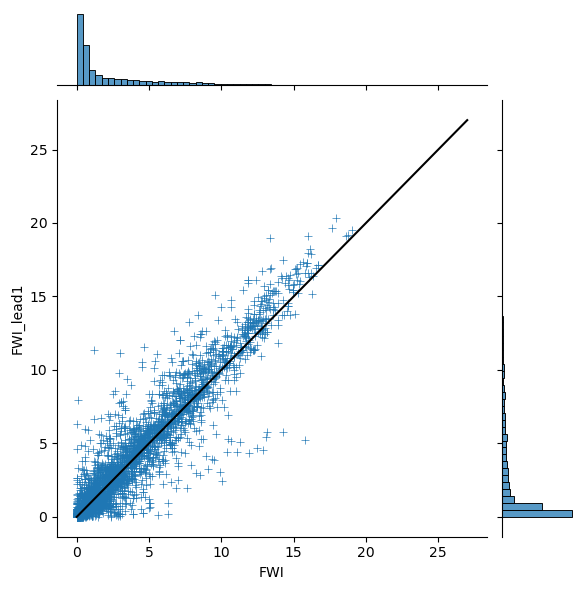

              FWI  FWI_lead_2
108           NaN         NaN
109      2.683968    0.955101
110     11.418555   14.016458
113      8.719515   10.520937
114      0.629906    0.267295
...           ...         ...
105611   1.137851    0.867270
105615   0.626205    0.603681
105617   0.934107    0.819871
105619   4.845189    6.209783
105621   5.189156    1.988978

[5120 rows x 2 columns]
Summary Statistics for lag 2
R^2 from 1:1 (Variance explained): 0.7114495213758278
Overall Bias/ mean predictor error: 0.2616496462491301


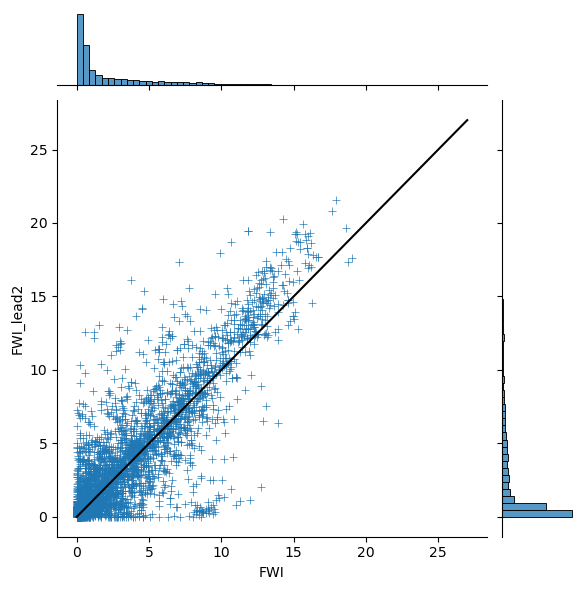

              FWI  FWI_lead_3
108           NaN         NaN
109      2.683968    0.420523
110     11.418555   14.630502
113      8.719515    9.820648
114      0.629906    0.341303
...           ...         ...
105611   1.137851    1.581345
105615   0.626205    0.812764
105617   0.934107    0.921643
105619   4.845189    7.168623
105621   5.189156    7.550240

[5120 rows x 2 columns]
Summary Statistics for lag 3
R^2 from 1:1 (Variance explained): 0.471589599594175
Overall Bias/ mean predictor error: 0.3402793264281838


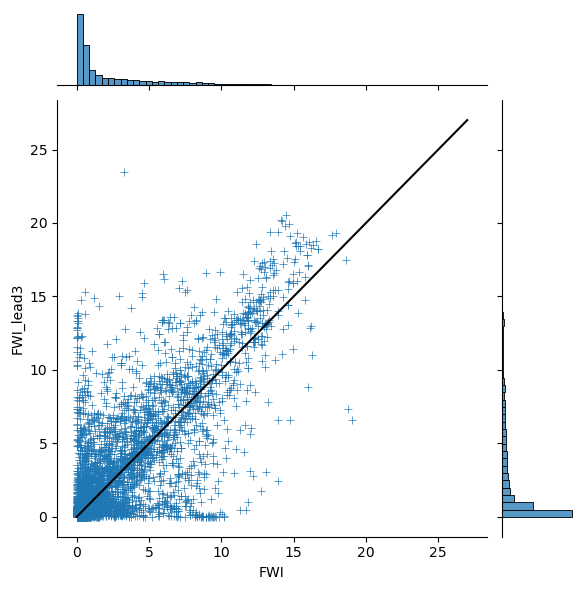

              FWI  FWI_lead_4
108           NaN         NaN
109      2.683968    0.709179
110     11.418555   13.414138
113      8.719515    9.241083
114      0.629906    0.486949
...           ...         ...
105611   1.137851    3.609831
105615   0.626205    0.559947
105617   0.934107    4.246021
105619   4.845189    6.265512
105621   5.189156   10.342582

[5120 rows x 2 columns]
Summary Statistics for lag 4
R^2 from 1:1 (Variance explained): 0.43547254669289515
Overall Bias/ mean predictor error: 0.39105264674445533


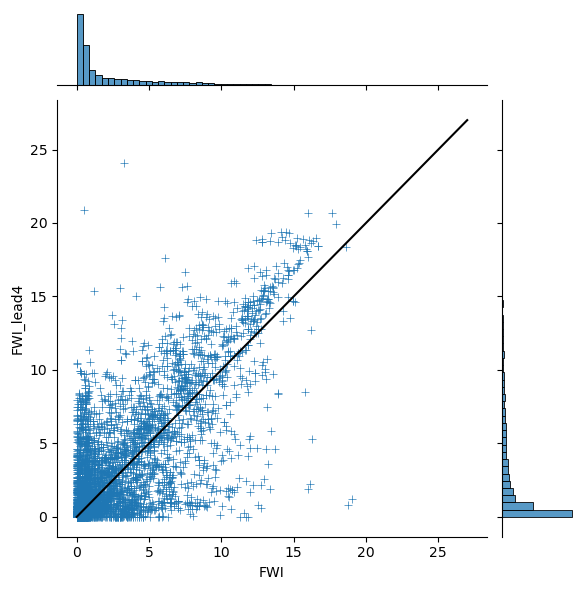

              FWI  FWI_lead_5
108           NaN         NaN
109      2.683968    0.674337
110     11.418555    9.812151
113      8.719515    5.251108
114      0.629906    0.189830
...           ...         ...
105611   1.137851    6.194089
105615   0.626205    9.214815
105617   0.934107    2.030996
105619   4.845189    8.304449
105621   5.189156   10.457526

[5120 rows x 2 columns]
Summary Statistics for lag 5
R^2 from 1:1 (Variance explained): 0.2201031061612293
Overall Bias/ mean predictor error: 0.14396769869990766


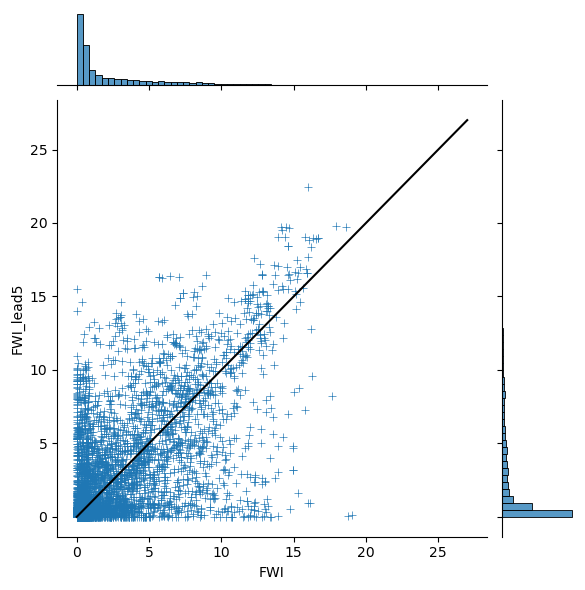

              FWI  FWI_lead_6
108           NaN         NaN
109      2.683968    0.606341
110     11.418555    8.670969
113      8.719515    5.408271
114      0.629906    0.599343
...           ...         ...
105611   1.137851    0.284459
105615   0.626205    8.920271
105617   0.934107    9.462615
105619   4.845189    8.422015
105621   5.189156    9.859728

[5120 rows x 2 columns]
Summary Statistics for lag 6
R^2 from 1:1 (Variance explained): 0.06480949675315395
Overall Bias/ mean predictor error: 0.10703116828273045


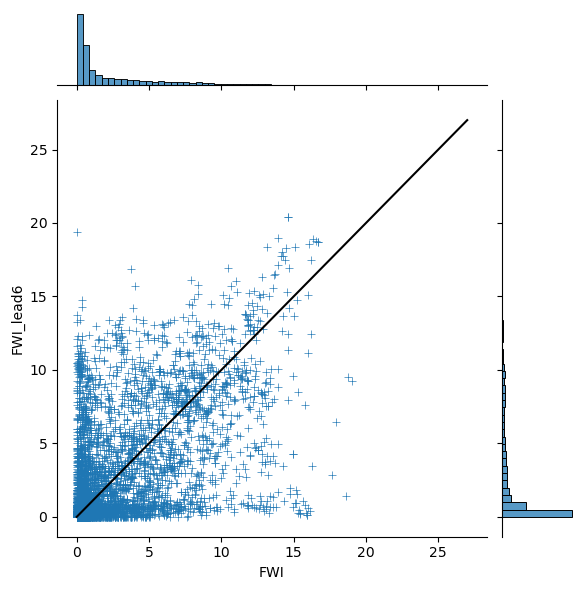

              FWI  FWI_lead_7
108           NaN         NaN
109      2.683968    2.067747
110     11.418555    8.733346
113      8.719515    2.862681
114      0.629906    0.000243
...           ...         ...
105611   1.137851    0.027194
105615   0.626205    2.279628
105617   0.934107    8.664633
105619   4.845189    1.798807
105621   5.189156   10.147943

[5120 rows x 2 columns]
Summary Statistics for lag 7
R^2 from 1:1 (Variance explained): -0.08633881980950675
Overall Bias/ mean predictor error: 0.05314824671453562


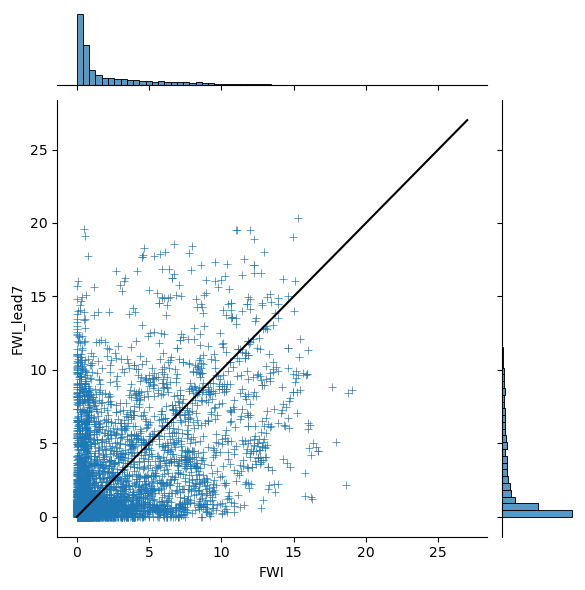

              FWI  FWI_lead_8
108           NaN         NaN
109      2.683968    0.000338
110     11.418555    1.585756
113      8.719515    6.908187
114      0.629906    0.725993
...           ...         ...
105611   1.137851    7.687182
105615   0.626205    3.382755
105617   0.934107    0.079705
105619   4.845189    0.534457
105621   5.189156    3.284271

[5120 rows x 2 columns]
Summary Statistics for lag 8
R^2 from 1:1 (Variance explained): -0.22152777164209025
Overall Bias/ mean predictor error: 0.05987678601170769


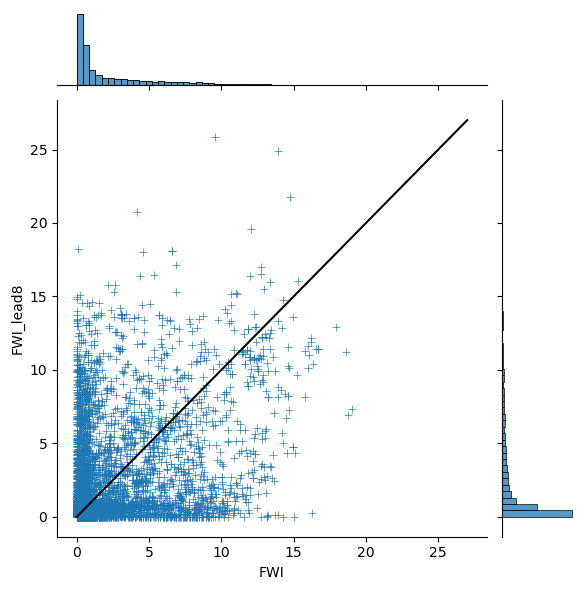

In [171]:
import seaborn as sns 

r_sq_list = []
bias_list = []
rmse_list = []
iterator = []

quantiles = [0.025, 0.975]
data = {'quantiles': quantiles}

boot_rmse = pd.DataFrame(data)
boot_r_sq = pd.DataFrame(data)
boot_bias = pd.DataFrame(data)

for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    sns.jointplot(data=log_fire, x="FWI", y=f"FWI_lead_{i}", marker="+") 
    plt.plot(range(0,28), range(0,28), color = "black")
    plt.xlabel("FWI")
    plt.ylabel(f"FWI_lead{i}")
    
    ## Stats
    r_sq = 1 - (np.sum((log_fire.FWI - log_fire[f"FWI_lead_{i}"])**(2)) / np.sum((log_fire.FWI - log_fire.FWI.mean())**(2)))
    bias = np.sum( log_fire[f"FWI_lead_{i}"] - log_fire.FWI )/len(log_fire[f"FWI_lead_{i}"])
    rmse = ((np.sum((log_fire[f"FWI_lead_{i}"] - log_fire.FWI)**2))/len(log_fire[f"FWI_lead_{i}"]))**(1/2)
    #print(log_fire[["FWI", f"FWI_lead_{i}"]])
    b_rsq = bootstrap_stat_quantiles(log_fire[["FWI", f"FWI_lead_{i}"]].dropna(), num_samps = 300, stat = fr_sq, quantiles = quantiles)
    b_bias = bootstrap_stat_quantiles(log_fire[["FWI", f"FWI_lead_{i}"]].dropna(), num_samps = 300, stat = fbias, quantiles = quantiles)
    b_rmse = bootstrap_stat_quantiles(log_fire[["FWI", f"FWI_lead_{i}"]].dropna(), num_samps = 300, stat = frmse, quantiles = quantiles)
    #plt.title(f"Comparison at lag {i}")
    print(f"Summary Statistics for lag {i}")
    print("R^2 from 1:1 (Variance explained): " + str(r_sq) )
    print("Overall Bias/ mean predictor error: " + str(bias) )
    rmse_list.append(rmse)
    r_sq_list.append(r_sq)
    bias_list.append(bias)
    iterator.append(i)
    boot_rmse = boot_rmse.merge(b_rmse, on = "quantiles")
    boot_r_sq = boot_r_sq.merge(b_rsq, on = "quantiles")
    boot_bias = boot_bias.merge(b_bias, on = "quantiles")
    
    plt.show()

decay_stats = pd.DataFrame({"lag_day": iterator, "RMSE": rmse_list, "r_sq": r_sq_list, "bias":bias_list, })

# here "*" is used as a marker for scatterplot 

In [170]:
boot_rmse

,quantiles,frmse_of_FWI_and_FWI_lead_1,frmse_of_FWI_and_FWI_lead_2,frmse_of_FWI_and_FWI_lead_3,frmse_of_FWI_and_FWI_lead_4,frmse_of_FWI_and_FWI_lead_5,frmse_of_FWI_and_FWI_lead_6,frmse_of_FWI_and_FWI_lead_7,frmse_of_FWI_and_FWI_lead_8
0,0.025,1.091171,1.840476,2.46608,2.551148,3.014140,3.331692,3.622435,3.938952
1,0.975,1.212391,1.994951,2.67634,2.740854,3.225202,3.547082,3.826802,4.153225


   quantiles  frmse_of_FWI_and_FWI_lead_1  frmse_of_FWI_and_FWI_lead_2  \
0      0.025                     1.095570                     1.823425   
1      0.975                     1.215447                     1.998619   

   frmse_of_FWI_and_FWI_lead_3  frmse_of_FWI_and_FWI_lead_4  \
0                     2.464066                     2.564412   
1                     2.658348                     2.745947   

   frmse_of_FWI_and_FWI_lead_5  frmse_of_FWI_and_FWI_lead_6  \
0                     3.019158                     3.337748   
1                     3.215776                     3.552883   

   frmse_of_FWI_and_FWI_lead_7  frmse_of_FWI_and_FWI_lead_8  
0                     3.603711                     3.927476  
1                     3.830409                     4.142302  


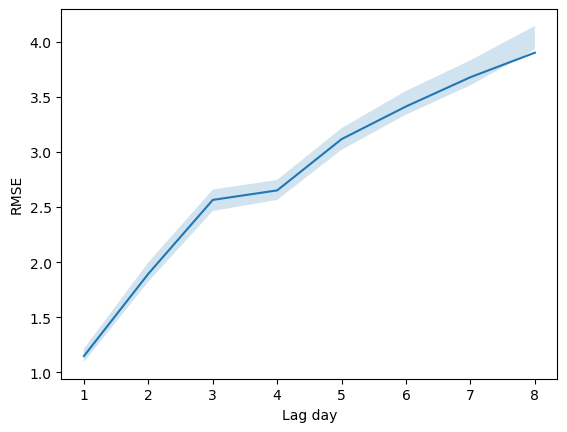

   quantiles  fr_sq_of_FWI_and_FWI_lead_1  fr_sq_of_FWI_and_FWI_lead_2  \
0      0.025                     0.882861                     0.682980   
1      0.975                     0.904865                     0.739256   

   fr_sq_of_FWI_and_FWI_lead_3  fr_sq_of_FWI_and_FWI_lead_4  \
0                     0.433328                     0.392967   
1                     0.519730                     0.483464   

   fr_sq_of_FWI_and_FWI_lead_5  fr_sq_of_FWI_and_FWI_lead_6  \
0                     0.162553                    -0.000075   
1                     0.276781                     0.125022   

   fr_sq_of_FWI_and_FWI_lead_7  fr_sq_of_FWI_and_FWI_lead_8  
0                    -0.174902                    -0.515891  
1                    -0.034735                    -0.329648  


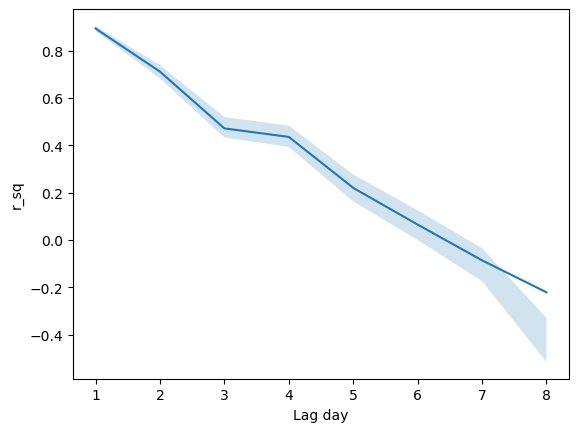

   quantiles  fbias_of_FWI_and_FWI_lead_1  fbias_of_FWI_and_FWI_lead_2  \
0      0.025                     0.141058                     0.213422   
1      0.975                     0.202396                     0.319464   

   fbias_of_FWI_and_FWI_lead_3  fbias_of_FWI_and_FWI_lead_4  \
0                     0.270640                     0.324245   
1                     0.413898                     0.455433   

   fbias_of_FWI_and_FWI_lead_5  fbias_of_FWI_and_FWI_lead_6  \
0                     0.064542                     0.012982   
1                     0.235280                     0.201028   

   fbias_of_FWI_and_FWI_lead_7  fbias_of_FWI_and_FWI_lead_8  
0                    -0.039624                    -0.045160  
1                     0.157956                     0.180646  


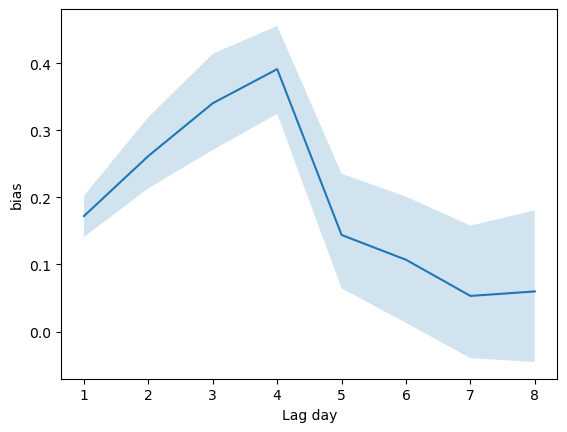

In [172]:
stats = ["RMSE", "r_sq", "bias"]
b_sts = [ boot_rmse, boot_r_sq, boot_bias ]

for s,b in zip(stats, b_sts):
    plt.plot(decay_stats.lag_day, decay_stats[s])
    upper = b.iloc[0, 1:]
    lower = b.iloc[1, 1:]
    print(b)
    plt.fill_between(decay_stats.lag_day, lower, upper, alpha=0.2, label='Confidence Interval')
    plt.xlabel("Lag day")
    plt.ylabel(s)
    plt.show()

In [16]:
bins = 10
slices = np.linspace(0, 100, bins+1, True)
slices

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [17]:
tmp = pd.qcut(small_fire.FWI.dropna(), 20, precision = 0)

tmp

109         (2.4, 3.2]
110       (10.7, 19.1]
113        (8.2, 10.7]
114         (0.5, 0.6]
117         (0.1, 0.2]
              ...     
105611      (0.9, 1.3]
105615      (0.5, 0.6]
105617      (0.9, 1.3]
105619      (4.1, 5.2]
105621      (5.2, 6.6]
Name: FWI, Length: 5118, dtype: category
Categories (20, interval[float64, right]): [(-0.09999999200000001, 0.003] < (0.003, 0.03] < (0.03, 0.1] < (0.1, 0.2] ... (5.2, 6.6] < (6.6, 8.2] < (8.2, 10.7] < (10.7, 19.1]]

In [18]:
#small_fire.FWI_round.unique()

/tmp/ipykernel_1461/3590388246.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_var = small_fire.groupby("FWI_round")[f"FWI_lead_{i}"].var().reset_index()
/tmp/ipykernel_1461/3590388246.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_var = small_fire.groupby("FWI_round")[f"FWI_lead_{i}"].var().reset_index()
/tmp/ipykernel_1461/3590388246.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_var = s

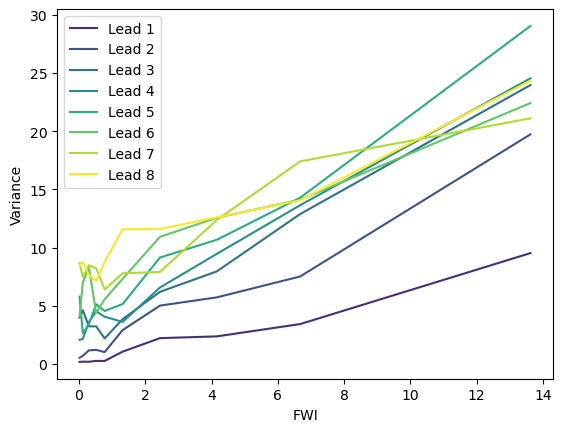

In [38]:
def get_mid(interval):
    return interval.mid

## Calculate the varience at different FWI and lag values
#small_fire["FWI_round"] = np.round(small_fire.FWI)
#small_fire["FWI_round"][small_fire["FWI_round"] >= 17] = 17
nbins = 10
small_fire["FWI_intervals"] = pd.qcut(small_fire.FWI.dropna(), nbins)
small_fire["FWI_round"] = small_fire.FWI_intervals.apply(lambda x: get_mid(x))



def calc_bias(df, i):
    tmp = np.sum( df[f"FWI_lead_{i}"] - df["FWI"])/len(df[f"FWI_lead_{i}"])
    #print(len(df["FWI"]))
    return(tmp)

def RMSE(df, i):
    tmp = (np.sum((df[f"FWI_lead_{i}"] - df["FWI"])**(2))/len(df[f"FWI_lead_{i}"]))**(1/2)
    return(tmp)

#cmap = plt.get_cmap('viridis')
colors = plt.cm.viridis(np.linspace(0,1,9))

for i in range(1,9):
    test_var = small_fire.groupby("FWI_round")[f"FWI_lead_{i}"].var().reset_index()
    #plt.plot(test_var.FWI_round, test_var[f"FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.plot(test_var.FWI_round, test_var[f"FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.xlabel("FWI")
    plt.ylabel(f"Variance")
    plt.legend()
    #plt.title(f"Comparison at lag {i}")
plt.show()

In [20]:
boot_df

,GEOS-5.IMERGEARLY,FWI,FWI_lead_1,FWI_lead_2,FWI_lead_3,FWI_lead_4,FWI_lead_5,FWI_lead_6,FWI_lead_7,FWI_lead_8,pre_fire,fwi_error_1,fwi_error_2,fwi_error_3,fwi_error_4,fwi_error_5,fwi_error_6,fwi_error_7,fwi_error_8
0,7.285453,5.916722,6.189273,5.338222,7.184546,8.168101,8.325221,0.607583,0.819865,6.001970,False,-0.272551,0.578500,-1.267824,-2.251379,-2.408499,5.309139,5.096857,-0.085248
1,0.377586,0.013186,0.013461,0.054615,0.082717,0.342484,0.976102,9.217630,0.122039,0.187102,False,-0.000275,-0.041429,-0.069531,-0.329298,-0.962917,-9.204444,-0.108853,-0.173917
2,3.025130,0.551829,0.545648,0.746263,0.750819,0.196548,0.952253,2.323853,0.118649,0.008151,False,0.006181,-0.194434,-0.198989,0.355282,-0.400424,-1.772023,0.433181,0.543678
3,0.142710,0.019236,0.043212,0.004285,0.023389,0.001173,0.000228,0.001968,2.333352,0.000144,False,-0.023976,0.014951,-0.004153,0.018063,0.019009,0.017268,-2.314116,0.019093
4,3.375293,0.774177,0.746931,1.002172,0.627657,0.615179,0.491121,0.102738,4.711157,0.574041,False,0.027246,-0.227995,0.146520,0.158998,0.283056,0.671439,-3.936980,0.200136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26214395,0.143519,0.413634,0.232421,0.262789,0.179044,0.121122,0.011333,0.282410,0.020002,1.282318,False,0.181212,0.150845,0.234590,0.292511,0.402301,0.131224,0.393632,-0.868685
26214396,0.219462,0.280818,0.894192,1.336487,0.595774,0.735053,1.283507,11.471714,NaN,2.206677,False,-0.613374,-1.055669,-0.314956,-0.454235,-1.002689,-11.190896,NaN,-1.925858
26214397,5.352182,1.553111,2.202443,1.314801,2.623782,0.285464,0.200765,0.084997,6.329949,0.040767,False,-0.649332,0.238311,-1.070670,1.267647,1.352346,1.468114,-4.776838,1.512344
26214398,1.839341,0.648080,0.810655,NaN,0.032822,0.013400,0.223148,NaN,0.404558,7.179006,False,-0.162575,NaN,0.615258,0.634680,0.424932,NaN,0.243522,-6.530926


/tmp/ipykernel_1461/3393328916.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_var = small_fire.groupby("FWI_round").apply(calc_bias, i = i).reset_index()
/tmp/ipykernel_1461/3393328916.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_var = small_fire.groupby("FWI_round").apply(calc_bias, i = i).reset_index()
/tmp/ipykernel_1461/3393328916.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_var = sm

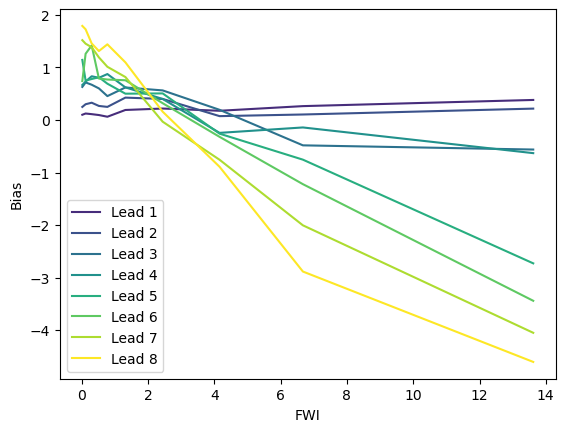

In [22]:
for i in range(1,9):
    test_var = small_fire.groupby("FWI_round").apply(calc_bias, i = i).reset_index()
    #print(test_var)
    test_var = test_var.rename(columns={0:f"FWI_lead_{i}"})
    plt.plot(test_var.FWI_round, test_var[f"FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.xlabel("FWI")
    plt.ylabel(f"Bias")
    plt.legend()
    #plt.title(f"Comparison at lag {i}")
plt.show()

/tmp/ipykernel_1461/1201289170.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_var = small_fire.groupby("FWI_round").apply(RMSE, i = i).reset_index()
/tmp/ipykernel_1461/1201289170.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_var = small_fire.groupby("FWI_round").apply(RMSE, i = i).reset_index()
/tmp/ipykernel_1461/1201289170.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_var = small_fire.g

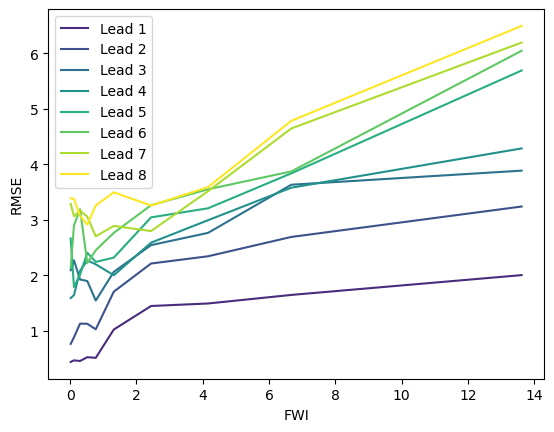

In [23]:
for i in range(1,9):
    test_var = small_fire.groupby("FWI_round").apply(RMSE, i = i).reset_index()
    #print(test_var)
    test_var = test_var.rename(columns={0:f"FWI_lead_{i}"})
    #print(test_var)
    plt.plot(test_var.FWI_round, test_var[f"FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.xlabel("FWI")
    plt.ylabel(f"RMSE")
    plt.legend()
    #plt.title(f"Comparison at lag {i}")
plt.show()

# Now try to see if I can capture "changes in the timeseries". 

The goal is to find a mechnism that rewards capturing inflection points. This could have a couple of meanings: 

"How many days in advance did we get the inflection point correct" <-- possbily useful interpretation


"Were we able to spot the inflection point when the 


"Were we better at predicting the weather when it was getting hotter(more FWI) ore colder (less FWI)?"
- Calculate deltas, color-code scatterplots by deltas? Calculate r^2 on binned-deltas like I'm doing with Bias/ variance? 
- plot delta vs delta like above
- somehow plot delta skill one axis, FWI on other
    - T_4 - T_3, indexed by T_4  compared to forecasted T_4 - T_3 @ T_4 (actual) (Aka "The difference between 
        - FWI @T_3 = 10 FWI @T_4 = 16, forecastsed @T_3 was 6 and @ T_4 was 9. "Real delta" was 6, "Forecasted delta" was 3. @ FWI of 16, Delta forecast was off by 3



In [24]:
small_fire

,GEOS-5.IMERGEARLY,FWI,FWI_lead_1,FWI_lead_2,FWI_lead_3,FWI_lead_4,FWI_lead_5,FWI_lead_6,FWI_lead_7,FWI_lead_8,...,fwi_error_1,fwi_error_2,fwi_error_3,fwi_error_4,fwi_error_5,fwi_error_6,fwi_error_7,fwi_error_8,FWI_intervals,FWI_round
108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,6.663517,2.683968,3.278344,0.955101,0.420523,0.709179,0.674337,0.606341,2.067747,0.000338,...,-0.594376,1.728868,2.263445,1.974789,2.009632,2.077627,0.616221,2.683630,"(1.72, 3.162]",2.4410
110,14.376276,11.418555,12.995580,14.016458,14.630502,13.414138,9.812151,8.670969,8.733346,1.585756,...,-1.577025,-2.597903,-3.211947,-1.995584,1.606404,2.747586,2.685209,9.832799,"(8.189, 19.053]",13.6210
113,11.418739,8.719515,9.762177,10.520937,9.820648,9.241083,5.251108,5.408271,2.862681,6.908187,...,-1.042662,-1.801422,-1.101134,-0.521569,3.468406,3.311243,5.856833,1.811328,"(8.189, 19.053]",13.6210
114,2.192048,0.629906,0.536526,0.267295,0.341303,0.486949,0.189830,0.599343,0.000243,0.725993,...,0.093380,0.362611,0.288604,0.142957,0.440076,0.030563,0.629663,-0.096087,"(0.4, 0.633]",0.5165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105611,1.224199,1.137851,1.444016,0.867270,1.581345,3.609831,6.194089,0.284459,0.027194,7.687182,...,-0.306165,0.270581,-0.443494,-2.471980,-5.056238,0.853392,1.110656,-6.549331,"(0.912, 1.72]",1.3160
105615,9.632295,0.626205,0.408371,0.603681,0.812764,0.559947,9.214815,8.920271,2.279628,3.382755,...,0.217834,0.022524,-0.186560,0.066257,-8.588611,-8.294066,-1.653423,-2.756550,"(0.4, 0.633]",0.5165
105617,6.858365,0.934107,0.669392,0.819871,0.921643,4.246021,2.030996,9.462615,8.664633,0.079705,...,0.264715,0.114237,0.012464,-3.311914,-1.096889,-8.528508,-7.730526,0.854402,"(0.912, 1.72]",1.3160
105619,9.550910,4.845189,5.879375,6.209783,7.168623,6.265512,8.304449,8.422015,1.798807,0.534457,...,-1.034186,-1.364594,-2.323434,-1.420322,-3.459259,-3.576825,3.046383,4.310732,"(3.162, 5.154]",4.1580


In [25]:
fire_delta = fire.sort_values(by = ["fireID", "t"])

In [26]:
def group_level_diff(df, var):
    df["diff_" + var] = df[var].diff()
    return(df)

In [27]:
fire_delta = fire_delta[["fireID", "t", 'GEOS-5.IMERGEARLY',
       'FWI', 'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4',
       'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8']]

#fire_delta = fire_delta.groupby("fireID").apply(group_level_diff, "FWI").reset_index()

In [28]:
# smol = fire_delta[fire_delta.fireID == "10013"]

# smol["diff_FWI"] = smol.FWI.diff()
# #smol[~smol.FWI.isna()]
# smol[smol.t >= "2023-05-03"]

In [29]:
fire_delta = fire_delta[fire_delta.t.str.contains("12:00:00")]

fire_delta = fire_delta.groupby("fireID").apply(group_level_diff, "FWI").reset_index( drop = True)


for i in range(1,9):
    fire_delta = fire_delta.groupby("fireID").apply(group_level_diff, f"FWI_lead_{i}").reset_index( drop = True)
fire_delta

,fireID,t,GEOS-5.IMERGEARLY,FWI,FWI_lead_1,FWI_lead_2,FWI_lead_3,FWI_lead_4,FWI_lead_5,FWI_lead_6,...,FWI_lead_8,diff_FWI,diff_FWI_lead_1,diff_FWI_lead_2,diff_FWI_lead_3,diff_FWI_lead_4,diff_FWI_lead_5,diff_FWI_lead_6,diff_FWI_lead_7,diff_FWI_lead_8
0,10013,2023-06-12 12:00:00.000,7.347266,5.601150,4.835715,4.761248,1.791924,2.405727,3.912608,0.748423,...,0.616365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10013,2023-06-13 12:00:00,8.583236,7.438308,8.126811,7.866229,8.462020,5.284267,6.873473,7.672627,...,0.018278,1.837159,3.291096,3.104981,6.670096,2.878540,2.960865,6.924204,0.194013,-0.598088
2,10013,2023-06-14 12:00:00,0.782067,0.096350,1.294911,2.012740,2.722108,0.864916,0.002558,0.000744,...,0.170754,-7.341959,-6.831900,-5.853490,-5.739912,-4.419351,-6.870915,-7.671883,6.691510,0.152477
3,10013,2023-06-15 12:00:00,0.003886,0.000604,0.028872,0.023335,0.012239,0.846518,0.659732,0.000313,...,4.447561,-0.095746,-1.266039,-1.989404,-2.709869,-0.018399,0.657173,-0.000431,-6.532233,4.276806
4,10013,2023-06-16 12:00:00,0.010016,0.001022,0.002349,0.000337,0.343065,0.008386,0.032126,1.015967,...,1.001257,0.000418,-0.026522,-0.022999,0.330826,-0.838132,-0.627606,1.015654,-0.354311,-3.446304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5113,9844,2023-06-16 12:00:00.000,1.062195,0.545285,1.001442,0.692041,0.666808,0.004841,0.001794,0.034118,...,5.707011,0.451475,0.904869,0.571916,0.666420,0.004279,-0.188711,-1.019246,-1.387489,-4.140467
5114,9844,2023-06-17 12:00:00.000,1.012092,0.653354,0.681234,1.427596,1.278125,0.761876,0.214896,0.004420,...,4.844947,0.108069,-0.320208,0.735555,0.611316,0.757035,0.213101,-0.029698,-2.668623,-0.862065
5115,9844,2023-06-18 12:00:00.000,2.050683,1.769401,2.064145,1.682978,2.776733,3.520042,1.458908,0.513711,...,1.102442,1.116047,1.382911,0.255382,1.498608,2.758167,1.244012,0.509290,0.011040,-3.742504
5116,9844,2023-06-19 12:00:00.000,4.382680,4.110859,3.469098,4.271158,2.881220,3.366909,5.312718,0.609032,...,1.372212,2.341458,1.404953,2.588180,0.104487,-0.153134,3.853810,0.095322,1.189294,0.269769


In [30]:
fire_delta.columns

Index(['fireID', 't', 'GEOS-5.IMERGEARLY', 'FWI', 'FWI_lead_1', 'FWI_lead_2',
       'FWI_lead_3', 'FWI_lead_4', 'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7',
       'FWI_lead_8', 'diff_FWI', 'diff_FWI_lead_1', 'diff_FWI_lead_2',
       'diff_FWI_lead_3', 'diff_FWI_lead_4', 'diff_FWI_lead_5',
       'diff_FWI_lead_6', 'diff_FWI_lead_7', 'diff_FWI_lead_8'],
      dtype='object')

Summary Statistics for lag 1
R^2 from 1:1 (Variance explained): 0.7431573508158458
Overall Bias/ mean predictor error: 0.008649941126222145


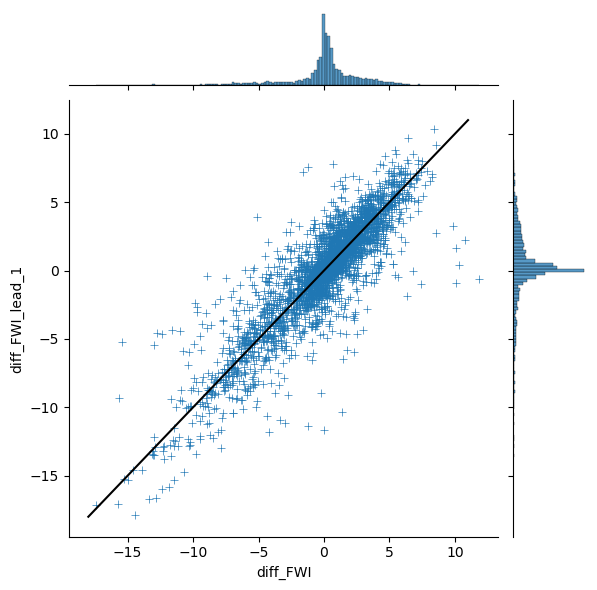

Summary Statistics for lag 2
R^2 from 1:1 (Variance explained): 0.3019553623996032
Overall Bias/ mean predictor error: -0.00823536640025682


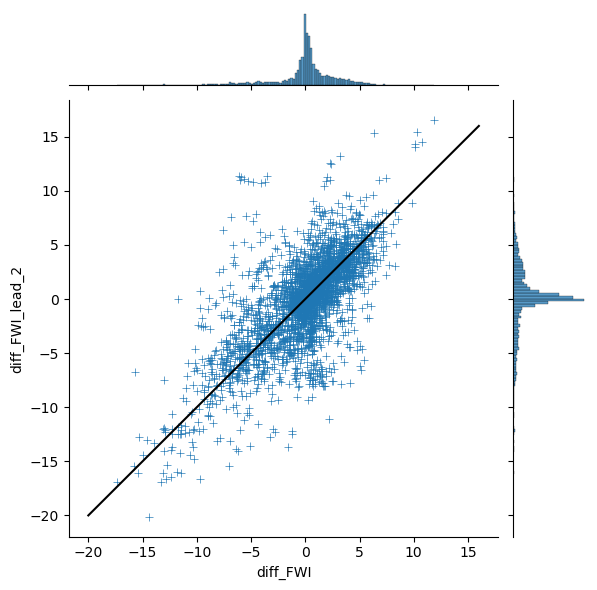

Summary Statistics for lag 3
R^2 from 1:1 (Variance explained): -0.21217186969528656
Overall Bias/ mean predictor error: 0.027675822231181774


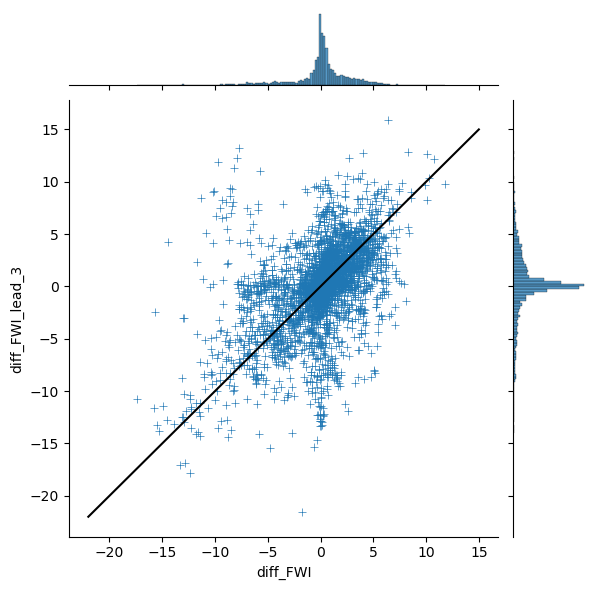

Summary Statistics for lag 4
R^2 from 1:1 (Variance explained): -0.2395252060891666
Overall Bias/ mean predictor error: 0.04588312881744429


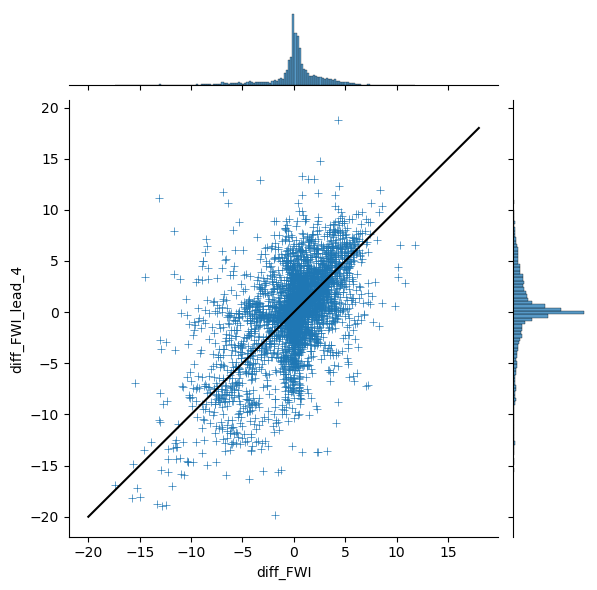

Summary Statistics for lag 5
R^2 from 1:1 (Variance explained): -0.8181648893144566
Overall Bias/ mean predictor error: 0.017965527391117477


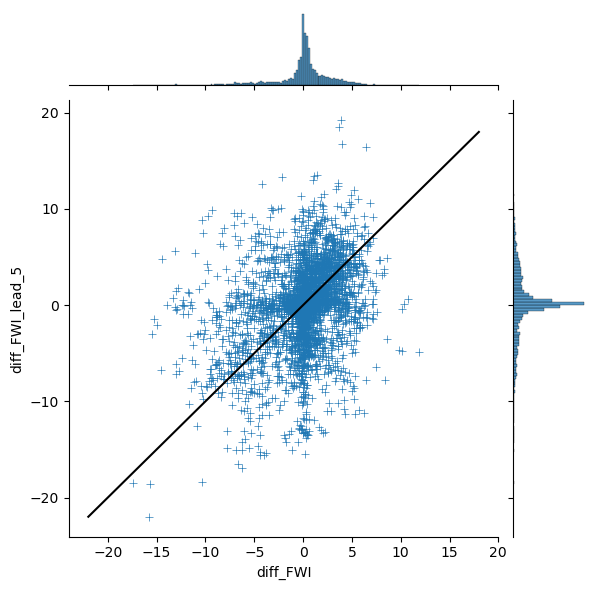

Summary Statistics for lag 6
R^2 from 1:1 (Variance explained): -0.9830710973592915
Overall Bias/ mean predictor error: 0.022844558547026904


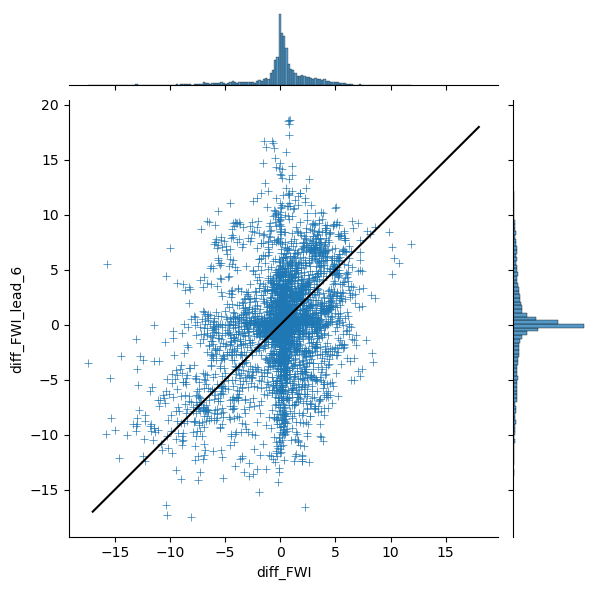

Summary Statistics for lag 7
R^2 from 1:1 (Variance explained): -1.446937674370865
Overall Bias/ mean predictor error: -0.01795421731847254


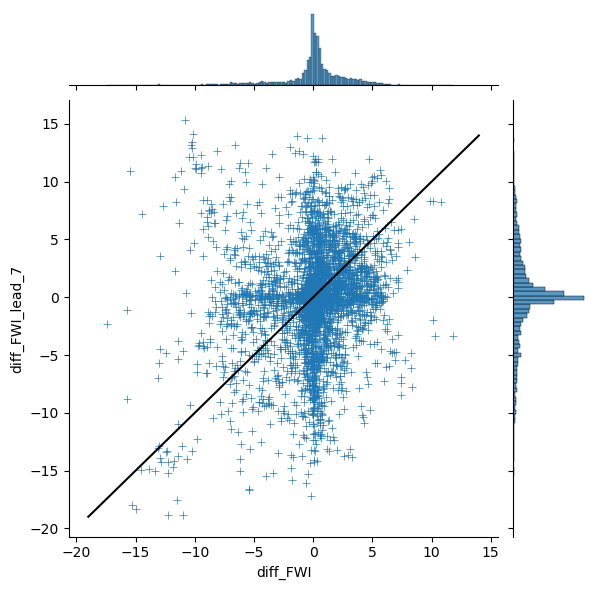

Summary Statistics for lag 8
R^2 from 1:1 (Variance explained): -1.5077458607587104
Overall Bias/ mean predictor error: -0.10069246681152996


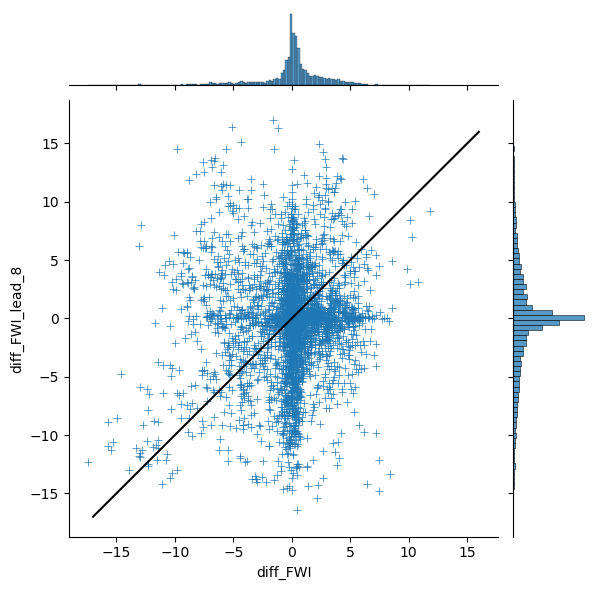

In [31]:
### Drop duplicates to account for oversampling

fire_delta = fire_delta[['FWI', 'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4',
       'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8', 'diff_FWI', 'diff_FWI_lead_1', 'diff_FWI_lead_2',
       'diff_FWI_lead_3', 'diff_FWI_lead_4', 'diff_FWI_lead_5',
       'diff_FWI_lead_6', 'diff_FWI_lead_7', 'diff_FWI_lead_8']]
fire_delta = fire_delta.drop_duplicates()


### Summary stats for CHANGE in FWI predictions

for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    sns.jointplot(data=fire_delta, x="diff_FWI", y=f"diff_FWI_lead_{i}", marker="+") 
    max_of_max = round(max(fire_delta[f"diff_FWI_lead_{i}"].max(), fire_delta.diff_FWI.max()))
    min_of_min = round(min(fire_delta[f"diff_FWI_lead_{i}"].min(), fire_delta.diff_FWI.min()))
    
    
    plt.plot(range(min_of_min, max_of_max), range(min_of_min, max_of_max), color = "black")
    plt.xlabel("diff_FWI")
    plt.ylabel(f"diff_FWI_lead_{i}")
    
    ## Stats
    r_sq = 1 - (np.sum((fire_delta.diff_FWI - fire_delta[f"diff_FWI_lead_{i}"])**(2)) / np.sum((fire_delta.diff_FWI - fire_delta.diff_FWI.mean())**(2)))
    bias = np.sum(fire_delta[f"diff_FWI_lead_{i}"] - fire_delta.diff_FWI )/len(fire_delta.diff_FWI)
    #plt.title(f"Comparison at lag {i}")
    print(f"Summary Statistics for lag {i}")
    print("R^2 from 1:1 (Variance explained): " + str(r_sq) )
    print("Overall Bias/ mean predictor error: " + str(bias) )
    plt.show()
    

In [32]:
fire_delta

,FWI,FWI_lead_1,FWI_lead_2,FWI_lead_3,FWI_lead_4,FWI_lead_5,FWI_lead_6,FWI_lead_7,FWI_lead_8,diff_FWI,diff_FWI_lead_1,diff_FWI_lead_2,diff_FWI_lead_3,diff_FWI_lead_4,diff_FWI_lead_5,diff_FWI_lead_6,diff_FWI_lead_7,diff_FWI_lead_8
0,5.601150,4.835715,4.761248,1.791924,2.405727,3.912608,0.748423,0.010586,0.616365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.438308,8.126811,7.866229,8.462020,5.284267,6.873473,7.672627,0.204599,0.018278,1.837159,3.291096,3.104981,6.670096,2.878540,2.960865,6.924204,0.194013,-0.598088
2,0.096350,1.294911,2.012740,2.722108,0.864916,0.002558,0.000744,6.896109,0.170754,-7.341959,-6.831900,-5.853490,-5.739912,-4.419351,-6.870915,-7.671883,6.691510,0.152477
3,0.000604,0.028872,0.023335,0.012239,0.846518,0.659732,0.000313,0.363875,4.447561,-0.095746,-1.266039,-1.989404,-2.709869,-0.018399,0.657173,-0.000431,-6.532233,4.276806
4,0.001022,0.002349,0.000337,0.343065,0.008386,0.032126,1.015967,0.009564,1.001257,0.000418,-0.026522,-0.022999,0.330826,-0.838132,-0.627606,1.015654,-0.354311,-3.446304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5113,0.545285,1.001442,0.692041,0.666808,0.004841,0.001794,0.034118,2.857591,5.707011,0.451475,0.904869,0.571916,0.666420,0.004279,-0.188711,-1.019246,-1.387489,-4.140467
5114,0.653354,0.681234,1.427596,1.278125,0.761876,0.214896,0.004420,0.188968,4.844947,0.108069,-0.320208,0.735555,0.611316,0.757035,0.213101,-0.029698,-2.668623,-0.862065
5115,1.769401,2.064145,1.682978,2.776733,3.520042,1.458908,0.513711,0.200008,1.102442,1.116047,1.382911,0.255382,1.498608,2.758167,1.244012,0.509290,0.011040,-3.742504
5116,4.110859,3.469098,4.271158,2.881220,3.366909,5.312718,0.609032,1.389302,1.372212,2.341458,1.404953,2.588180,0.104487,-0.153134,3.853810,0.095322,1.189294,0.269769


In [33]:
#type(fire_delta.FWI)

#tmp = pd.cut(fire_delta.FWI.values, bins= 5, include_lowest = True)




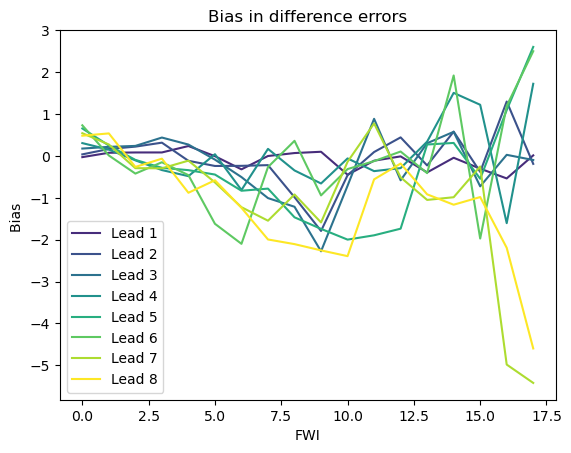

In [34]:
### See if there is systematic bias in the differenced stuff

## Calculate the varience at different FWI and lag values
fire_delta["FWI_round"] = np.round(fire_delta.FWI)
fire_delta["FWI_round"][fire_delta["FWI_round"] > 17] = 17
#fire_delta["FWI_binned"] = pd.cut(fire_delta.FWI.values, bins= 5, include_lowest = True) ## Becomes catagorical data an messes up plotting below


# def calc_bias(df, i):
#     tmp = np.sum(df[f"FWI_lead_{i}"] - df["FWI"])/len(df[f"FWI_lead_{i}"])
#     return(tmp)

def calc_bias_diff(df, i):
    tmp = np.sum( df[f"diff_FWI_lead_{i}"] - df["diff_FWI"])/len(df[f"diff_FWI_lead_{i}"])
    #print(len(df[f"diff_FWI_lead_{i}"]))
    #print(df["FWI_round"].unique())
    return(tmp)

def RMSE_diff(df, i):
    tmp = (np.sum((df[f"diff_FWI_lead_{i}"] - df["diff_FWI"])**(2))/len(df[f"diff_FWI_lead_{i}"]))**(1/2)
    return(tmp)

    

#cmap = plt.get_cmap('viridis')
colors = plt.cm.viridis(np.linspace(0,1,9))

bin_var = "FWI_round" # "FWI_round"
for i in range(1,9):
    test_var = fire_delta.groupby(bin_var).apply(calc_bias_diff, i = i).reset_index()
    #print(test_var)
    test_var = test_var.rename(columns={0:f"diff_FWI_lead_{i}"})
    plt.plot(test_var[bin_var], test_var[f"diff_FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.xlabel("FWI")
    plt.ylabel(f"Bias ")
    plt.title("Bias in difference errors")
    plt.legend()
    #plt.title(f"Comparison at lag {i}")
plt.show()

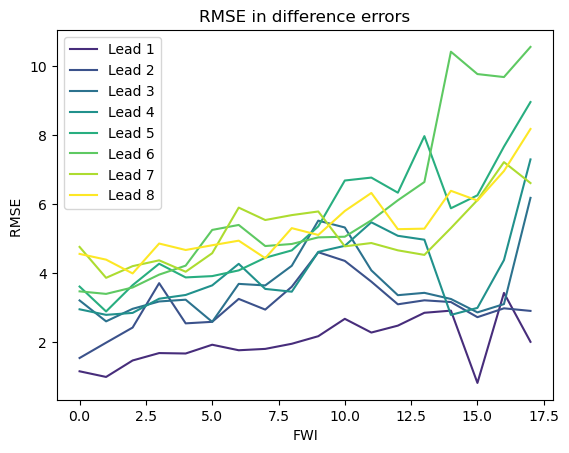

In [35]:
bin_var = "FWI_round" # "FWI_round"
for i in range(1,9):
    test_var = fire_delta.groupby(bin_var).apply( RMSE_diff, i = i).reset_index()
    #print(test_var)
    test_var = test_var.rename(columns={0:f"diff_FWI_lead_{i}"})
    plt.plot(test_var[bin_var], test_var[f"diff_FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.xlabel("FWI")
    plt.ylabel(f"RMSE ")
    plt.title("RMSE in difference errors")
    plt.legend()
    #plt.title(f"Comparison at lag {i}")
plt.show()    

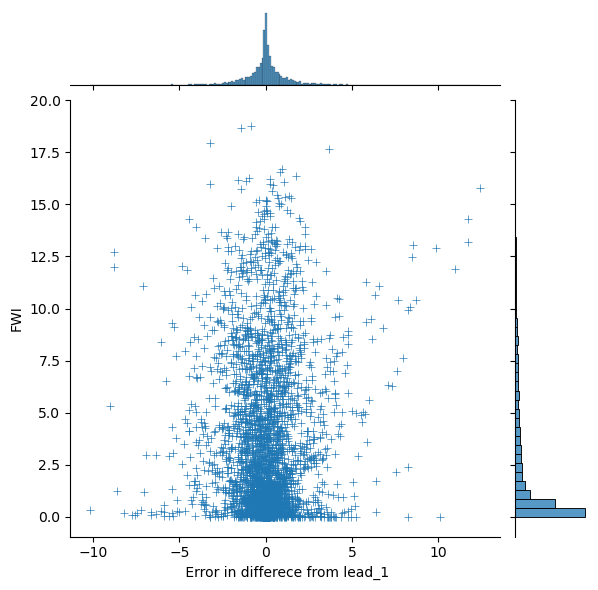

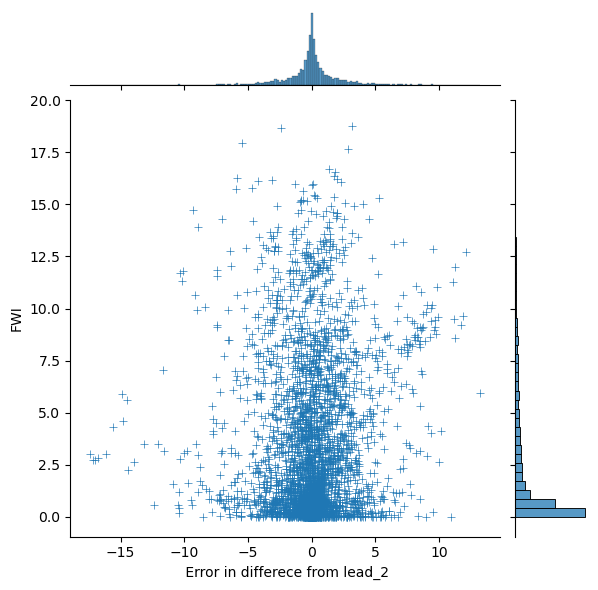

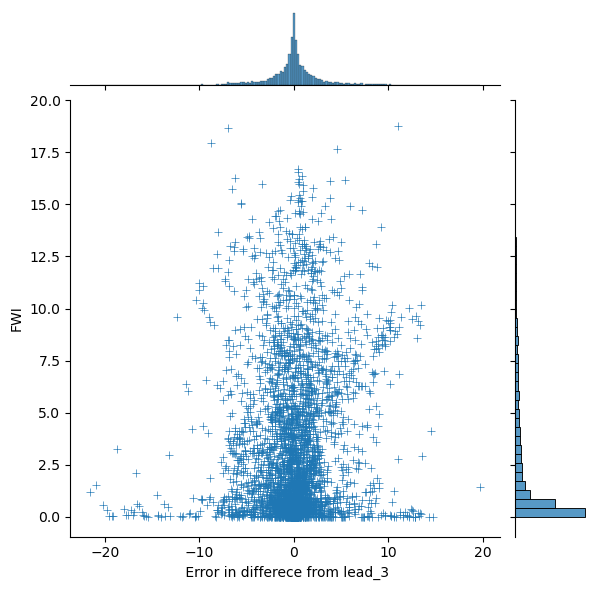

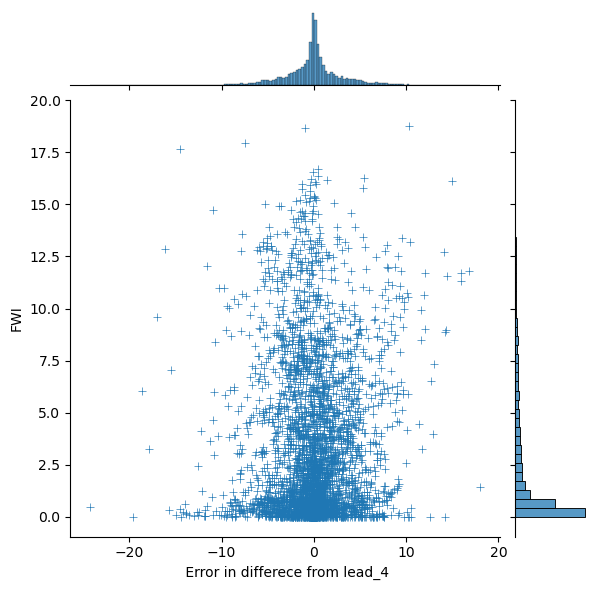

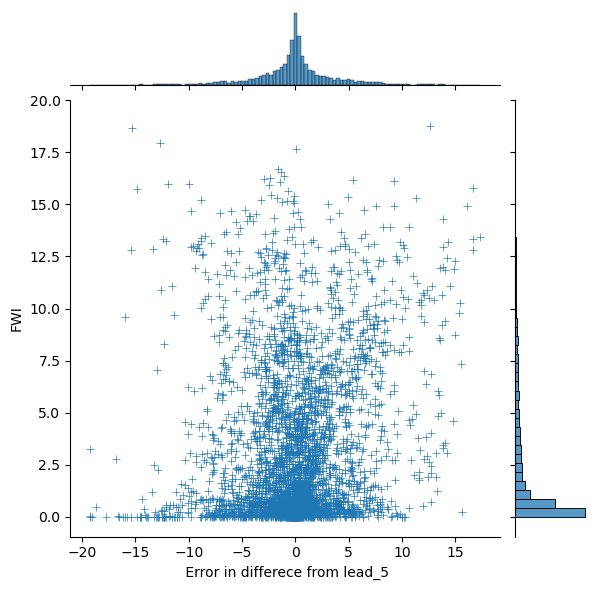

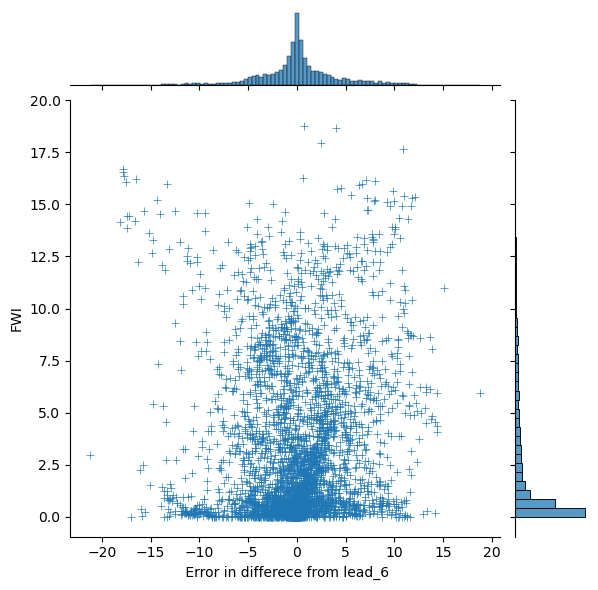

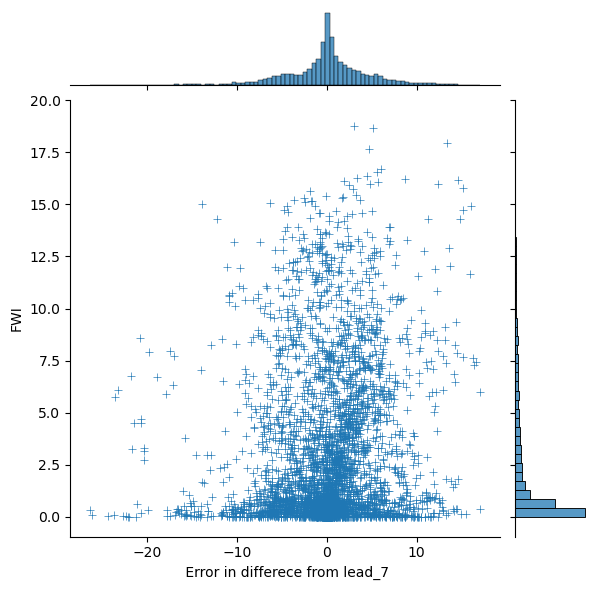

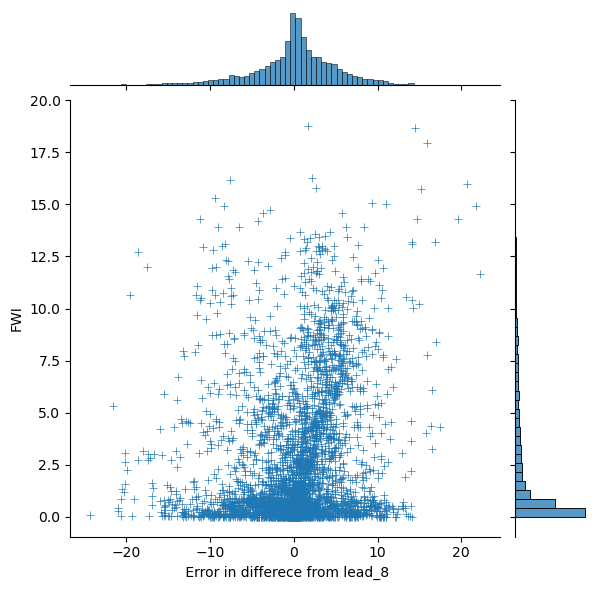

In [36]:
## Plot error by FWI

for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    sns.jointplot(data=fire_delta, y="FWI", x=fire_delta.diff_FWI - fire_delta[f"diff_FWI_lead_{i}"], marker="+") 
    #max_of_max = round(max(fire_delta[f"diff_FWI_lead_{i}"].max(), fire_delta.diff_FWI.max()))
    #min_of_min = round(min(fire_delta[f"diff_FWI_lead_{i}"].min(), fire_delta.diff_FWI.min()))
    
    
    #plt.plot(range(min_of_min, max_of_max), range(min_of_min, max_of_max), color = "black")
    plt.ylabel("FWI")
    plt.xlabel(f" Error in differece from lead_{i}")
    
    ## Stats
    plt.show()